## 机器翻译数据集

### 数据集引入

In [ ]:
import torch
import torch.nn as nn

# 直接读取
with open('data/有英语-中文普通话对应句 - 2023-02-18.tsv', encoding='utf-8') as f:
    lines = f.readlines()
print(lines[:5])

In [ ]:
# 只读取有效内容
with open('data/有英语-中文普通话对应句 - 2023-02-18.tsv', encoding='utf-8') as f:
    data = []
    for line in f.readlines():
        data.append(line.strip().split('\t')[1]+'\t'+line.strip().split('\t')[3])
print(data[:5])

In [ ]:
# 找出特殊字符
import re
import string

content = ''.join(data)
special_char = re.sub(r'[\u4e00-\u9fa5]', ' ', content)  # 匹配中文，将中文替换掉

print(set(special_char) - set(string.ascii_letters) - set(string.digits))

### 数据清洗

In [ ]:
def cleaning(data):
    for i in range(len(data)):
        # 替换特殊字符
        data[i] = data[i].replace('\u200b', '')
        data[i] = data[i].replace('\u200f', '')
        data[i] = data[i].replace('\xad', '')
        data[i] = data[i].replace('\u3000', ' ')
        eng_mark = [',', '.', '!', '?'] # 因为标点前加空格
        for mark in eng_mark:
            data[i] = data[i].replace(mark, ' '+mark)
        data[i] = data[i].lower()  # 统一替换为小写
    return data

In [ ]:
cleaning(data)

In [ ]:
def tokenize(data):
    # 分别存储源语言和目标语言的词元
    src_tokens, tgt_tokens = [], []
    for line in data:
        pair = line.split('\t')
        src = pair[0].split(' ')
        tgt = list(pair[1])
        src_tokens.append(src)
        tgt_tokens.append(tgt)
    return src_tokens, tgt_tokens

src_tokens, tgt_tokens = tokenize(data)
print("src:", src_tokens[:6])
print("tgt:", tgt_tokens[:6])

In [7]:
import numpy as np
def statistics(tokens):
    max_len = 80 #只统计长度80以下的
    len_list = range(max_len)  # 长度值
    freq_list = np.zeros(max_len)  # 频率值
    for token in tokens:
        if len(token) < max_len:
            freq_list[len_list.index(len(token))] += 1
    return len_list, freq_list

s1, s2 = statistics(src_tokens)
t1, t2 = statistics(tgt_tokens)

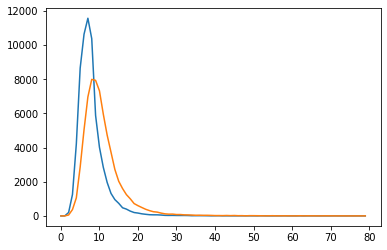

In [8]:
import matplotlib.pyplot as plt
plt.plot(s1,s2)
plt.plot(t1,t2)

### 构建词表

In [9]:
from collections import Counter  #计数类

flatten = lambda l: [item for sublist in l for item in sublist]  #展平数组

# 构建词表
class Vocab:
    def __init__(self, tokens):
        self.tokens = tokens  # 传入的tokens是二维列表
        self.token2index = {'<bos>': 0, '<eos>': 1, '<unk>':2, '<pad>':3}  # 先存好特殊词元
        # 将词元按词频排序后生成列表
        self.token2index.update({
            token: index + 4
            for index, (token, freq) in enumerate(
                sorted(Counter(flatten(self.tokens)).items(), key=lambda x: x[1], reverse=True))
        }) 
        #构建id到词元字典
        self.index2token = {index: token for token, index in self.token2index.items()}
 
    def __getitem__(self, query):
        # 单一索引
        if isinstance(query, (str, int)):
            if isinstance(query, str):
                return self.token2index.get(query, 0)
            elif isinstance(query, (int)):
                return self.index2token.get(query, '<unk>')
        # 数组索引
        elif isinstance(query, (list, tuple)):
            return [self.__getitem__(item) for item in query]
 
    def __len__(self):
        return len(self.index2token)

### 构建数据集

In [12]:
from torch.utils.data import DataLoader, TensorDataset

seq_len = 48  # 序列最大长度

# 对数据按照最大长度进行截断和填充
def padding(tokens, seq_len):
    # 该函数针对单个句子进行处理
    # 传入的句子是词元形式
    return tokens[:seq_len] if len(tokens) > seq_len else tokens + ['<pad>'] * (seq_len - len(tokens))

#实例化source和target词表
src_vocab, tgt_vocab = Vocab(src_tokens), Vocab(tgt_tokens)

#增加结尾标识<eos>
src_data = torch.tensor([src_vocab[padding(line + ['<eos>'], seq_len)] for line in src_tokens])
tgt_data = torch.tensor([tgt_vocab[padding(line + ['<eos>'], seq_len)] for line in tgt_tokens])

# 训练集和测试集比例8比2，batch_size = 16
train_size = int(len(src_data) * 0.8)
test_size = len(src_data) - train_size
batch_size = 256

train_loader = DataLoader(TensorDataset(src_data[:train_size], tgt_data[:train_size]), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(src_data[-test_size:], tgt_data[-test_size:]), batch_size=1)

## 模型训练

### 模型定义

In [11]:
# 定义编码器
class Encoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size, padding_idx=3)  # 将token表示为embedding
        self.gru = nn.GRU(ebd_size, hidden_size, num_layers=num_layers)
 
    def forward(self, encoder_inputs):
        # encoder_inputs从(batch_size, seq_len)变成(batch_size, seq_len, emb_size)再调整为(seq_len, batch_size, emb_size)
        encoder_inputs = self.embedding(encoder_inputs).permute(1, 0, 2)
        output, hidden = self.gru(encoder_inputs)
        # hidden 的形状为 (num_layers, batch_size, hidden_size)
        # 最后时刻的最后一个隐层的输出的隐状态即为上下文向量
        return hidden

# 定义解码器
class Decoder(nn.Module):
 
    def __init__(self, vocab_size, ebd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, ebd_size, padding_idx=3)
        # 拼接维度ebd_size + hidden_size
        self.gru = nn.GRU(ebd_size + hidden_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
 
    def forward(self, decoder_inputs, encoder_states):
        '''
            decoder_inputs 为目标序列偏移一位的结果, 由初始形状: (batch_size, seq_len)变为(batch_size, seq_len)
            再调整为(batch_size, seq_len, emb_size) -> (seq_len, batch_size, emb_size)
        '''
        decoder_inputs = self.embedding(decoder_inputs).permute(1, 0, 2)
        context = encoder_states[-1] # 上下文向量取编码器的最后一个隐层的输出
        # context 初始形状为 (batch_size, hidden_size)，为下一步连接，需repeat为(seq_len, batch_size, hidden_size)形式 
        context = context.repeat(decoder_inputs.shape[0], 1, 1)
        output, hidden = self.gru(torch.cat((decoder_inputs, context), -1), encoder_states)
        # logits 的形状为 (seq_len, batch_size, vocab_size)
        logits = self.linear(output)
        return logits, hidden

# seq2seq模型
class Seq2Seq(nn.Module):
 
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
 
    def forward(self, encoder_inputs, decoder_inputs):
        return self.decoder(decoder_inputs, self.encoder(encoder_inputs))

### 模型训练

In [12]:
from tqdm import *
import matplotlib.pyplot as plt

# 设置是否使用GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 设置超参数
lr = 0.001
num_epochs = 50
hidden_size = 256

# 建立模型
encoder = Encoder(len(src_vocab), len(src_vocab), hidden_size, num_layers=2)
decoder = Decoder(len(tgt_vocab), len(tgt_vocab), hidden_size, num_layers=2)
model = Seq2Seq(encoder, decoder)
model.to(device)

# 交叉熵损失及adam优化器
criterion = nn.CrossEntropyLoss(reduction='none', ignore_index =3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 记录损失变化
loss_history = []

#开始训练
model.train()
for epoch in tqdm(range(num_epochs)):
    for encoder_inputs, decoder_targets in train_loader:
        encoder_inputs, decoder_targets = encoder_inputs.to(device), decoder_targets.to(device)
        # 偏移一位作为decoder的输入
        # decoder的输入第一位是<bos>
        bos_column = torch.tensor([tgt_vocab['<bos>']] * decoder_targets.shape[0]).reshape(-1, 1).to(device)
        decoder_inputs = torch.cat((bos_column, decoder_targets[:, :-1]), dim=1)
        # pred的形状为 (seq_len, batch_size, vocab_size)
        pred, _ = model(encoder_inputs, decoder_inputs)
        # decoder_targets 的形状为 (batch_size, seq_len)，我们需要改变pred的形状以保证它能够正确输入
        # loss 的形状为 (batch_size, seq_len)，其中的每个元素都代表了一个词元的损失
        loss = criterion(pred.permute(1, 2, 0), decoder_targets).mean()

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

100%|██████████| 50/50 [1:36:32<00:00, 115.86s/it]  


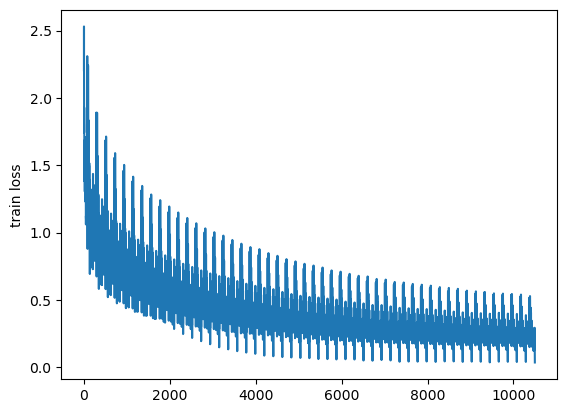

In [13]:
plt.plot(loss_history)
plt.ylabel('train loss')
plt.show()

###  模型保存

In [17]:
# 保存模型
torch.save(model.state_dict(), 'seq2seq_params.pt')

## 模型评估

### bleu指标

In [24]:
import math
# 计算bleu分数
def bleu(label, pred, n):
    score = math.exp(min(0, 1 - len(label) / len(pred)))
    for k in range(1, n + 1):
        num_matches = 0
        hashtable = Counter([' '.join(label[i:i + k]) for i in range(len(label) - k + 1)])
        for i in range(len(pred) - k + 1):
            ngram = ' '.join(pred[i:i + k])
            if ngram in hashtable and hashtable[ngram] > 0:
                num_matches += 1
                hashtable[ngram] -= 1
        score *= pow(num_matches / (len(pred) - k + 1), pow(0.5, k))
    return score

### 测试集评估

In [26]:
model.eval()
translation_results = []
bleu_scores = []
# 因为batch_size是1，所以每次取出来的都是单个句子
for src_seq, tgt_seq in test_loader:
    encoder_inputs = src_seq
    hidden = model.encoder(encoder_inputs.to(device))
    pred_seq = [tgt_vocab['<bos>']]
    for _ in range(8):
        # 一步步输出，decoder的输入的形状为(batch_size, seq_len)=(1,1)
        decoder_inputs = torch.tensor(pred_seq[-1]).reshape(1, 1).to(device)
        # pred形状为 (seq_len, batch_size, vocab_size) = (1, 1, vocab_size)
        pred, hidden = model.decoder(decoder_inputs, hidden)
        next_token_index = pred.squeeze().argmax().item()
        if next_token_index == tgt_vocab['<eos>']:
            break
        pred_seq.append(next_token_index)
    
    # 去掉开头的<bos>
    pred_seq = tgt_vocab[pred_seq[1:]]
    # 因为tgt_seq的形状为(1, seq_len)，我们需要将其转化成(seq_len, )的形状
    tgt_seq = tgt_seq.squeeze().tolist()
    
    # 需要注意在<eos>之前截断
    if tgt_vocab['<eos>'] in tgt_seq:
        eos_idx = tgt_seq.index(tgt_vocab['<eos>'])
        tgt_seq = tgt_vocab[tgt_seq[:eos_idx]]
    else:
        tgt_seq = tgt_vocab[tgt_seq]
    translation_results.append((' '.join(tgt_seq), ' '.join(pred_seq)))
    bleu_scores.append(bleu(tgt_seq, pred_seq, n=2))

In [27]:
print(sum(bleu_scores) / test_size)

0.16821586571116853


### 模型效果

In [ ]:
translation_results